In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tangent_boundaries as tb
from math import pi
from scipy.sparse import csr_matrix, csc_matrix, linalg as sla
from functools import partial

sigma_0 = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

## Build a function that generates some other shape

In [26]:
def generate_elipse(r1,r2,npoints=1000):
    'Generates the set of points in the grid closest to an elipse with radii r1 and r2 and the angle of the normal vector.'
    theta = np.linspace(0, 2*np.pi, npoints)
    x = r1*np.cos(theta)
    y = r2*np.sin(theta)
    angles = np.arctan((r1/r2)*np.tan(theta))
    z = np.exp(1j*angles)

    boundary_points, indices = np.unique(np.round(np.stack((x, y))), axis = 1, return_inverse=True)

    # Calculate the sum of elements in z that correspond to the same value in mask
    sums_real = np.bincount(indices, weights=z.real)
    sums_imag = np.bincount(indices, weights=z.imag)
    
    # Calculate the count of elements in b that correspond to the same value in mask
    counts = np.bincount(indices)
    
    # Calculate the average of elements in b that correspond to the same value in mask
    normal_angles = np.angle((sums_real + 1j*sums_imag)/counts)
    

    
    return boundary_points, normal_angles

/tmp/ipykernel_22298/828742761.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


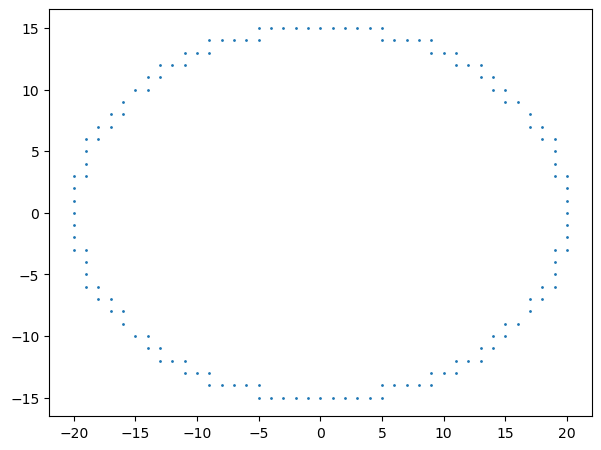

In [27]:
boundary_points, normal_angles = generate_elipse(20,15)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(boundary_points[0],boundary_points[1], s = 1)

ax.set_aspect('equal')
fig.show()

### Now we have to incorporate this into the function that builds the Hamiltonian.

In [28]:
#Testing

Nx = 43
Ny = 35
def get_index(x,y,s):
    '''Returns the index of the orbital in x,y with spin s'''
    return int(Nx*Ny*s + Nx*y + x)

edge_points, normal_angles = generate_elipse(r1 = Nx//2, r2 = Ny//2)
edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])

indices_to_delete = []

#Delete edges
for point in zip(edge_points[0], edge_points[1]):
    #book index to delete
    indices_to_delete.append(get_index(point[0],point[1],1))


#Delete outside
amount_out = 0
X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
for x,y in zip(X.ravel(),Y.ravel()):
    if ((x-Nx//2)/(Nx//2))**2+((y-Ny//2)/(Ny//2))**2 > 1 and  get_index(x,y,1) not in indices_to_delete:
        indices_to_delete.append(get_index(x,y,0))
        indices_to_delete.append(get_index(x,y,1))
        amount_out += 1

In [29]:
inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)

inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)

/tmp/ipykernel_22298/3942523850.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


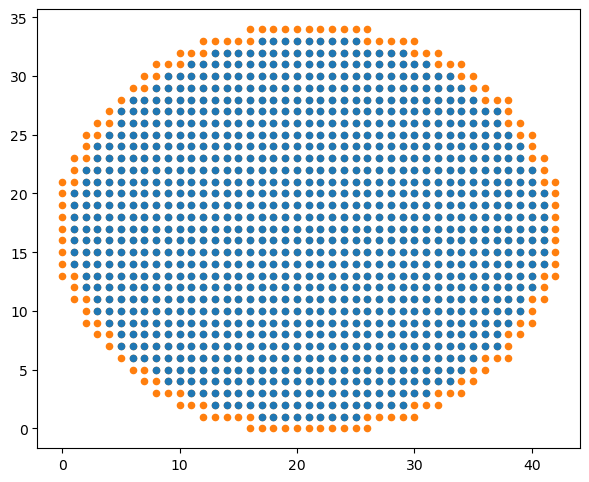

In [30]:
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111)
ax.scatter(inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:], s = 20)
ax.scatter(inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out], s = 20,zorder=-1)

ax.set_aspect('equal')
fig.show()

## It sems that this approach for obtaining indices to delete works

In [31]:
def operators_ellipse(parameters, plot_potential = False, plot_mass = False, plot_mag_field = False,return_shape = False):
    '''Returns operators Phi, H and P for a square 
    geometry boundary condition given by a magnetization that rotates parallel to the edge.'''
    
    Nx = parameters['Nx']     # Number of unit cells in x direction (should be odd)
    Ny = parameters['Ny']     # Number of unit cells in y direction (should be odd)
    kx = 0    # open system
    ky = 0    # open system
    
    #Generate Peierls phases
    #np.random.seed(0)
    if parameters['B1'] == 0:
        a_e = np.zeros((Ny,Nx))
        a_n = np.zeros((Ny,Nx))
    else:
        fluxes = make_fluxes(parameters, plot = plot_mag_field)
        a_e, a_n = vector_potential(parameters,fluxes)
        
    parameters['a_e'] = a_e
    parameters['a_n'] = a_n
    
    
    row_Tx = []
    col_Tx = []
    data_Tx = []
    
    row_Ty = []
    col_Ty = []
    data_Ty = []    

    for i in range(Nx*Ny):
        y = i//Nx
        x = i%Nx
        
        #Peierls phases
        p_e = np.exp(1j*(a_e[y,x]))
        p_n = np.exp(1j*(a_n[y,x]))
        
        #Standard translations
        trs_e = np.exp(-(1j*kx*Nx)*((x+1)//Nx))
        trs_n = np.exp(-(1j*ky*Ny)*((y+1)//Ny))
        
        #Total phases
        phase_e = p_e*trs_e
        phase_n = p_n*trs_n
        
        row_Tx += [i]
        col_Tx += [((x+1)%Nx) + y*Nx]
        data_Tx += [phase_e*(1-(x//(Nx-1)))] ################## Open boundaries in x direction
        
        row_Ty += [i]
        col_Ty += [x + ((y+1)%Ny)*Nx]
        data_Ty += [phase_n*(1-(y//(Ny-1)))] ################## Open boundaries in y direction
        
    # Sparse matrices corresponding to translation operators
    Tx = csc_matrix((data_Tx, (row_Tx, col_Tx)), shape = (Nx*Ny, Nx*Ny))
    Ty = csc_matrix((data_Ty, (row_Ty, col_Ty)), shape = (Nx*Ny, Nx*Ny))
    one = scipy.sparse.identity(Nx*Ny)
    
    phi_x = (Tx+one)/2
    phi_y = (Ty+one)/2
    sin_x = -(1j/2)*(Tx-Tx.H)
    sin_y = -(1j/2)*(Ty-Ty.H)
    
    hx = phi_y.H@sin_x@phi_y
    hy = phi_x.H@sin_y@phi_x
    phi = (phi_x@phi_y+phi_y@phi_x)/2

    potential_array = make_potential(parameters, plot = plot_potential).flatten()    
    pot = scipy.sparse.spdiags(potential_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    V = scipy.sparse.kron(csc_matrix(sigma_0), pot, format = "csc")    
    
    mass_array = make_mass(parameters, plot = plot_mass).flatten()    
    mass = scipy.sparse.spdiags(mass_array, 0, Nx*Ny, Nx*Ny, format = "csc")
    M = scipy.sparse.kron(csc_matrix(sigma_z), mass, format = "csc")
    
    
    H_0 = scipy.sparse.kron(csc_matrix(sigma_x), hx, format = "csc") + scipy.sparse.kron(csc_matrix(sigma_y), hy, format = "csc")
    Phi = scipy.sparse.kron(csc_matrix(sigma_0), phi, format = "csc")

    H = H_0 + Phi.H@V@Phi + Phi.H@M@Phi

    
    # Unitary transformation on the edges. Let us build a rotation matrix that acts on a single site.
    def spin_rotation(site, theta, phi):
        'Unitary transformation that rotates the spin site to a (theta,phi) orientation'
        rotation = np.identity(2*Nx*Ny, dtype = complex)
        
        spinup = site[0] + site[1]*Nx
        spindown = site[0] + site[1]*Nx + Nx*Ny
        
        rotation[spinup,spinup] = np.cos(theta/2)
        rotation[spinup,spindown] = np.sin(theta/2)
        rotation[spindown,spinup] = -np.sin(theta/2)*np.exp(1j*phi)
        rotation[spindown,spindown] = np.cos(theta/2)*np.exp(1j*phi)
        
        return csc_matrix(rotation)
        
    # Now rotate the spins on the edge
    def get_index(x,y,s):
        '''Returns the index of the orbital in x,y with spin s'''
        return int(Nx*Ny*s + Nx*y + x)

    edge_points, normal_angles = generate_elipse(r1 = Nx//2, r2 = Ny//2)
    edge_points = edge_points + np.array([[Nx//2]*(len(edge_points[1])),[Ny//2]*(len(edge_points[1]))])
    # the parameter that we need for the spin rotation is the projection of the boundary spin o the plane, so the normal plus pi/2.
    boundary_spin_projections = normal_angles + np.ones(len(normal_angles))*pi/2
    
    theta = parameters['theta']
    indices_to_delete = []
    
    for point in zip(edge_points[0], edge_points[1], boundary_spin_projections):
        
        #rotate
        rotation = spin_rotation([point[0],point[1]], theta, point[2]) 
        H = rotation.H@H@rotation
        Phi = rotation.H@Phi@rotation
        
        #book index to delete
        indices_to_delete.append(get_index(point[0],point[1],1))

    #Now we also have to delete the outer part
    amount_out = 0
    X,Y = np.meshgrid(np.arange(0,Nx),np.arange(0,Ny))
    for x,y in zip(X.ravel(),Y.ravel()):
        if ((x-Nx//2)/(Nx//2))**2+((y-Ny//2)/(Ny//2))**2 > 1 and  get_index(x,y,1) not in indices_to_delete:
            indices_to_delete.append(get_index(x,y,0))
            indices_to_delete.append(get_index(x,y,1))
            amount_out += 1

            
    # Transforming the sparse matrix into dense to delete spins (could I avoid this?)
    H_aux = H.toarray()
    Phi_aux = Phi.toarray()
   
    
    H_aux = np.delete(H_aux, indices_to_delete, axis=0)
    H_aux = np.delete(H_aux, indices_to_delete, axis=1)
    
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=0)
    Phi_aux = np.delete(Phi_aux, indices_to_delete, axis=1)
        
    H = csc_matrix(H_aux)
    Phi = csc_matrix(Phi_aux)
    P = Phi.H@Phi

    if return_shape:
        inside_indices = np.delete(np.arange(2*Nx*Ny), indices_to_delete)
        inside_x = inside_indices%(np.ones(len(inside_indices))*Nx)
        inside_y = (inside_indices//(np.ones(len(inside_indices))*Nx))%(np.ones(len(inside_indices))*Ny)
        inside_s = inside_indices//(np.ones(len(inside_indices))*Nx*Ny)
    
        return Phi, H, P, indices_to_delete, (inside_x[Nx*Ny-amount_out:],inside_y[Nx*Ny-amount_out:]), (inside_x[:Nx*Ny-amount_out],inside_y[:Nx*Ny-amount_out])
    else:
        return Phi, H, P, indices_to_delete